In [180]:
%matplotlib inline

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join
import re

import pandas as pd

import utils

In [172]:
# read files from dirs
BASE_DIR = './spearmint-config'

In [173]:
def parse_run_log(path, xcols, run_id="something" ):
    with open(path) as f:
        data = []
        for l in f.readlines():
            output = float(re.findall(r"y=(.+)", l)[0])
            job_id = int(re.findall(r"job #\s*(\d+)", l)[0])
            xs = map( lambda x : float(x), re.findall(r"\((.+)\)", l)[0].split(',') )
            data.append((run_id,job_id,output,*xs))
        return pd.DataFrame(data, columns= ['job_id', 'job_run', 'y'] + xcols)
            
parse_run_log( '%s/%s/%s' % (BASE_DIR,'goldstein_price_2d/runs', '1496875564' ), ['x1','x2'], run_id'1496875564')

,job_id,job_run,y,x1,x2
0,1496875564,1,24376.000000,-2.00000,-2.00000
1,1496875564,2,600.000000,0.00000,0.00000
2,1496875564,3,315857.874716,1.99891,-2.00000
3,1496875564,4,608747.095845,-0.83127,2.00000
4,1496875564,5,18975.248260,-2.00000,-1.08106
5,1496875564,6,548310.970656,-1.99854,1.78219
6,1496875564,7,89718.645278,-1.99999,0.41809
7,1496875564,8,2676.903598,2.00000,1.14413
8,1496875564,9,181.142330,2.00000,0.42958
9,1496875564,10,1585.175353,2.00000,0.82465


In [269]:
def retrieve_runs_from_dir(dirname, xcols, runs_dir="runs"):
    dir_path = "%s/%s/%s/"  % ( BASE_DIR, dirname, runs_dir )
    data = []
    for f in listdir(dir_path):
        if not isfile(join(dir_path, f)):
            continue
        
        df = parse_run_log( '%s/%s' % (dir_path, f ), xcols, f)
        
        data.append(df)
    return data

results = retrieve_runs_from_dir('goldstein_price_2d', ['x1','x2'])

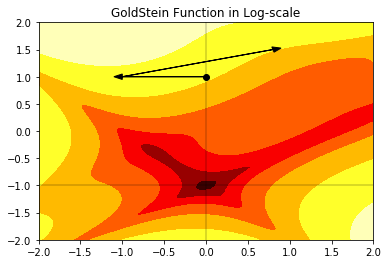

In [270]:
def plotGoldSteinEvaluation(sampling_points, title="GoldStein Function in Log-scale"):
    xx_N = 100
    lin_range = 2
    xx_lin = np.linspace(-lin_range, lin_range, xx_N)
    yy_lin = np.linspace(-lin_range, lin_range, xx_N)
    xx_g, yy_g = np.meshgrid(xx_lin, yy_lin)
    vec_goldstein = np.vectorize(utils.goldstein_price)

    z = np.log(vec_goldstein(xx_g, yy_g))

    plt.contourf(xx_g, yy_g, z, cmap='hot')

    plt.plot([0, 0], [-lin_range, lin_range], 'k-', lw=0.3)
    plt.plot([-lin_range, lin_range], [-1, -1], 'k-', lw=0.3)
    
    if len(sampling_points) > 0:
        plt.scatter(sampling_points[0,0], sampling_points[0,1], color = "k", marker = "o")

        for i in range(1,len(sampling_points)):
            prev = sampling_points[i-1]
            curr = sampling_points[i]
            plt.arrow(prev[0], prev[1], curr[0] - prev[0], curr[1] - prev[1], head_width=0.1, head_length=0.1, fc='k', ec='k')
            
    plt.title(title)
    
sampling_data = np.array([(0,1), (-1,1), (0.8,1.5)])
plotGoldSteinEvaluation(sampling_data)

# Spearmint walks on GoldStein Function

Goldstein Price Optimization from 20 Bayesian Optimization Runs in 10 steps


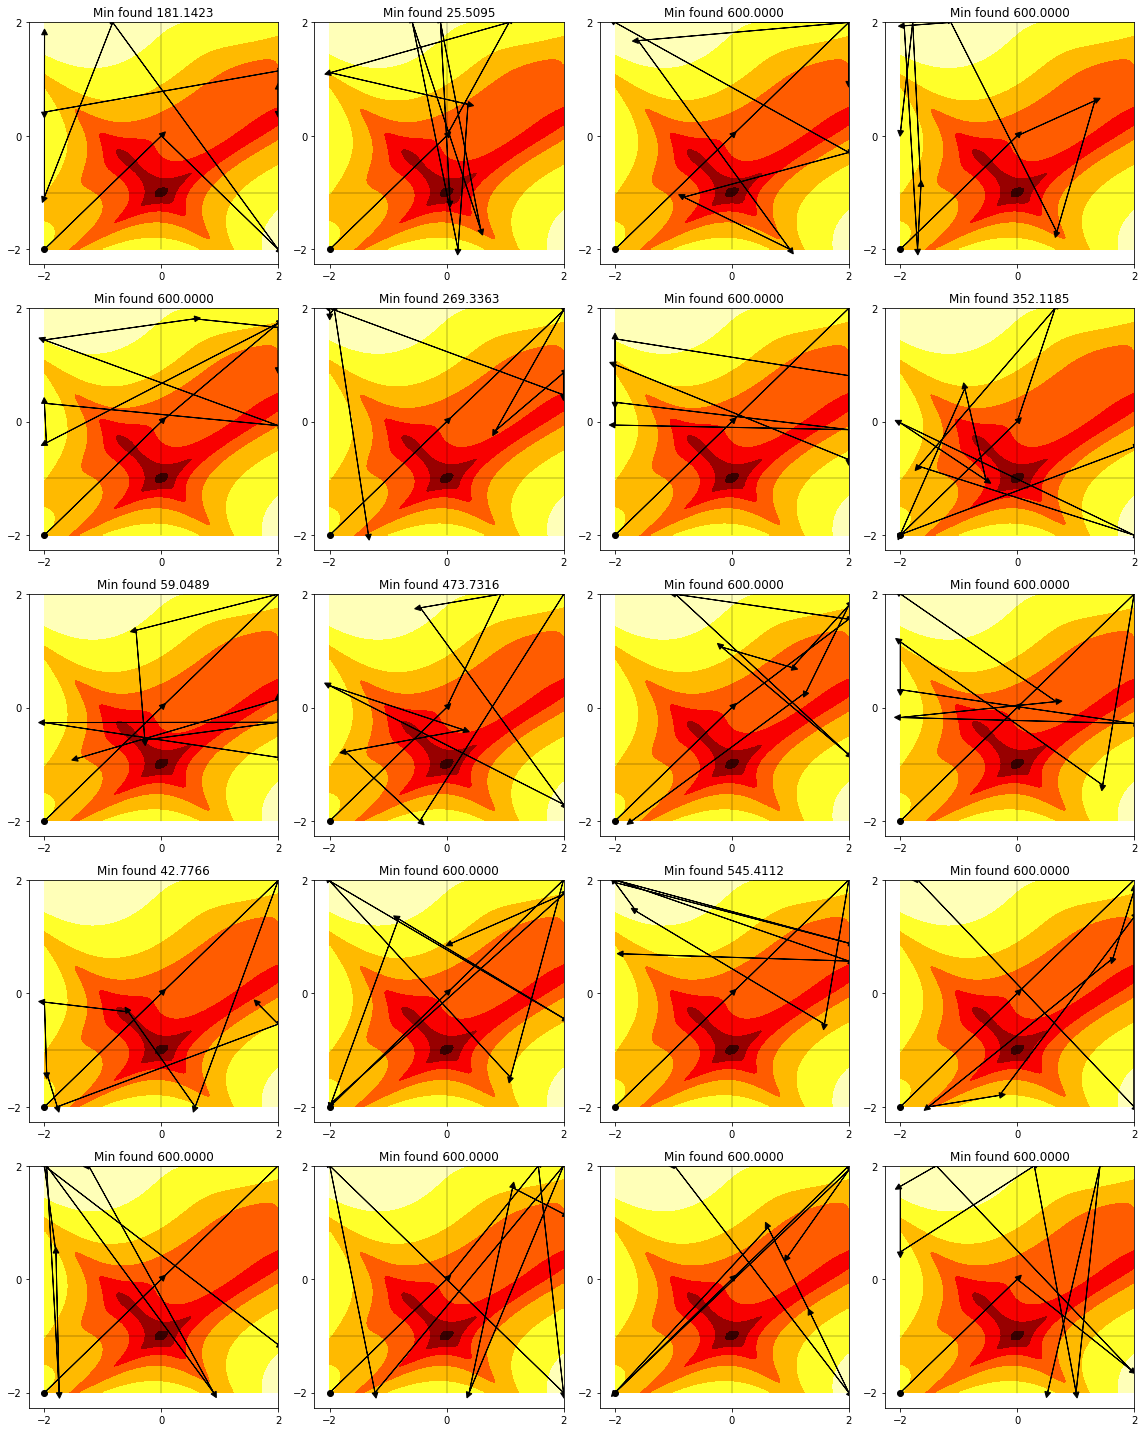

In [271]:
plt.figure(figsize=(16,20))

print('Goldstein Price Optimization from 20 Bayesian Optimization Runs in 10 steps')

for i in range(len(results)):

    df = results[i]
    data = df.as_matrix(columns=['x1','x2'])
    y_min = df.y.min()
    plt.subplot(5,4, i+1)
    title = "Min found %5.4f" % y_min
    plotGoldSteinEvaluation(data,title=title)
    plt.xticks([-2,0,2])
    plt.yticks([-2,0,2])
plt.tight_layout()

# Spearmint on GP functions

In [177]:
x_2d, a_2d, min_2d, max_2d = utils.loadData(2, 'testing')

In [179]:
print(x_2d[0].shape)
print(a_2d.shape)

(6, 2)
(2000, 6, 1)


In [182]:
DIM = 2
N_BUMPS = 6
LENGTH = 2.0/N_BUMPS*np.sqrt(DIM)

def kernel(x1,x2):
    return np.exp(-1.0/LENGTH**2*np.sum((np.expand_dims(x1,axis=2) - np.expand_dims(x2,axis=1))**2, axis = 3))


def GP(X,A,x):
    k_xX = kernel(x,X)
    return np.squeeze(np.matmul(k_xX,  A),axis=(2,))

def normalize(minv, maxv, y):
    return 2*(y-minv)/(maxv-minv)-1.0

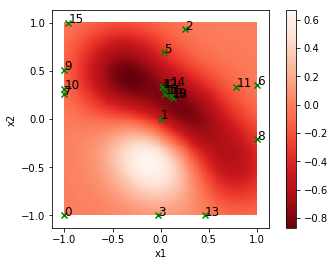

In [267]:
# Read data from config file
def plot_gp_function(data_idx = 1, colorbar=False):
    X = np.expand_dims(x_2d[data_idx], axis=0)
    A = a_2d[data_idx]
    miv = min_2d[data_idx]
    mxv = max_2d[data_idx]
    
    xx_N = 100
    xx1 = np.linspace(-1, 1, xx_N)
    xx2 = np.linspace(-1, 1, xx_N)
    
    xx = np.array(np.meshgrid(xx1,xx2)).T.reshape(1,-1,2)
    z = GP(X,A, xx).T
    z_norm = normalize(miv, mxv, z)
    
    plt.imshow(z_norm.reshape(xx_N,xx_N), cmap='Reds_r', interpolation='nearest', extent=[-1,1,-1,1], origin="lower")
   
    if colorbar:
        plt.colorbar()

    plt.xlabel('x1')
    plt.ylabel('x2')
    
    log_name = 'gp-%d' % data_idx
    df = parse_run_log( '%s/%s/%s' % (BASE_DIR,'gp-test/runs', log_name ), ['x1','x2'], run_id=log_name)
    
    sampling_points = df[['x1','x2']].as_matrix()

    plt.scatter(sampling_points[:,0], sampling_points[:,1], color = "green", marker = "x")
    for i in range(len(sampling_points)):
        curr = sampling_points[i]
        plt.text(curr[0], curr[1], str(i), fontsize=12, color="black")
    # Evaluate GP
    # plot heat map
    
    # parse log
plot_gp_function(data_idx=100, colorbar=True)

In [215]:
GP_TEST_INDICES = [100, 5, 90, 71, 2, 999, 33, 400, 500]

" ".join(map(str,GP_TEST_INDICES))

'100 5 90 71 2 999 33 400 500'

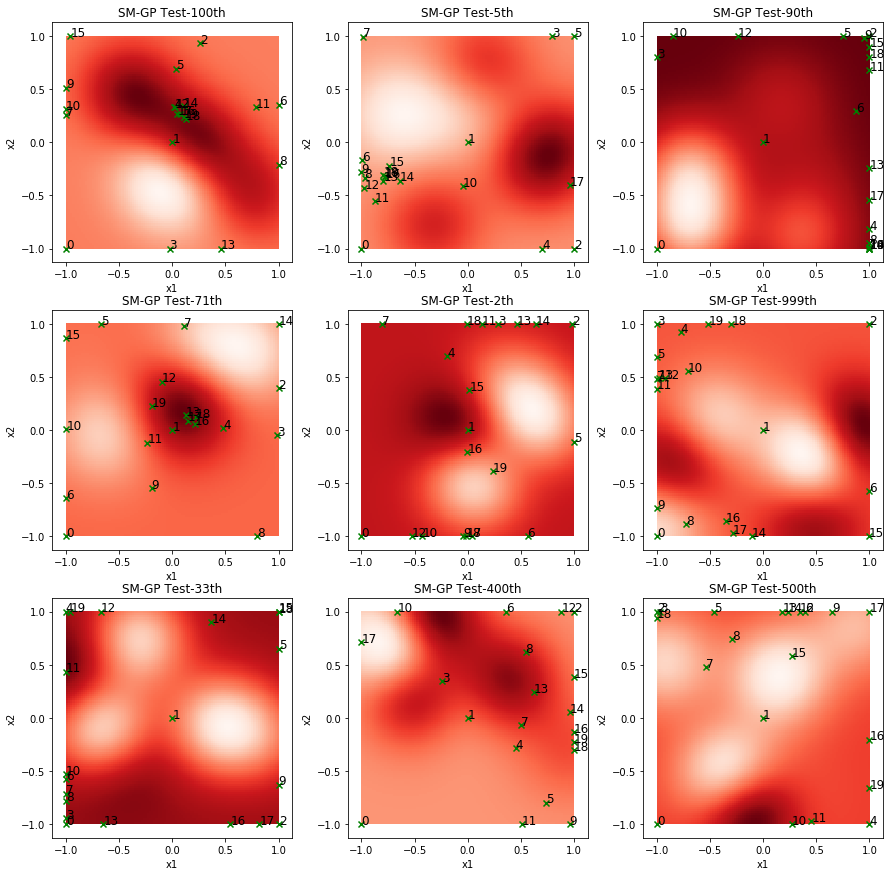

In [265]:
plt.figure(figsize=(15,15))
for i in range(len(GP_TEST_INDICES)):
    idx = GP_TEST_INDICES[i]
    plt.subplot(3,3,i+1)
    plot_gp_function(data_idx=idx)
    plt.title('SM-GP Test-%dth' % idx)

In [213]:
def evaluate_gp_at_point(data_idx, x1,x2):
    X = np.expand_dims(x_2d[data_idx], axis=0)
    A = a_2d[data_idx]
    miv = min_2d[data_idx]
    mxv = max_2d[data_idx]
    
    xx = np.array([x1,x2]).reshape(1,1,2);

    z = GP(X,A, xx).T
    z_norm = normalize(miv, mxv, z)
    return z_norm
evaluate_gp_at_point(71, -1,-1)

array([[ 0.12905712]])

In [ ]:
GP_TEST_INDEX = 400
def plot_gp_min_found():
    evaluation_steps = range(0,20)
    y = np.log(-np.arange(0,5,20))

In [266]:
parse_run_log( '%s/%s/%s' % (BASE_DIR,'gp-test/runs', 'gp-71' ), ['x1','x2'], run_id='gp-71')

,job_id,job_run,y,x1,x2
0,gp-71,1,0.129057,-1.00000,-1.00000
1,gp-71,2,-0.639407,0.00000,0.00000
2,gp-71,3,0.932736,0.99979,0.39683
3,gp-71,4,0.439311,0.98239,-0.04543
4,gp-71,5,-0.358976,0.47848,0.01794
5,gp-71,6,0.122048,-0.67162,1.00000
6,gp-71,7,0.133875,-1.00000,-0.63578
7,gp-71,8,0.197928,0.11067,0.98133
8,gp-71,9,0.196177,0.79654,-1.00000
9,gp-71,10,0.651170,-0.19421,-0.54403


In [422]:
results_gp_400th = retrieve_runs_from_dir('gp-test-ith', ['x1','x2'], runs_dir='runs-400-th')

In [423]:
len(results_gp_400th)

84

In [410]:
import unittest
tc = unittest.TestCase('__init__')

def min_up_to_k(data):
    total = len(data)
    mins_up_to_k = [data[0]]
    
    for k in range(1, total):
        m = mins_up_to_k[k-1]
        if mins_up_to_k[k-1] > data[k]:
            m = data[k]
        mins_up_to_k.append(m)
        
    return mins_up_to_k

tc.assertEqual(min_up_to_k([1,3,0.5,2,8,3,4]),[1,1,0.5,0.5,0.5,0.5,0.5])

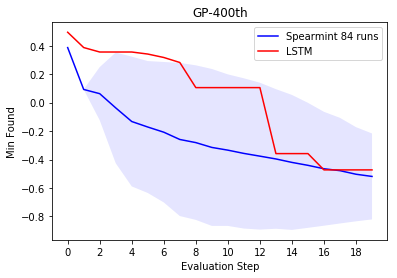

In [424]:
%store -r lstm_eval_gp_400_th

def plot_min_across_runs(data, color="blue") :
    mins_across_runs = []
    total = len(data)
    for  i in range(total):
        df = data[i]
        mins = min_up_to_k(df.y.as_matrix())
        mins_across_runs.append(mins)
        
    # mins_across_runs.shape = run*step
    # aka each step is each column
    mins_across_runs = np.vstack(mins_across_runs)
    
    mean_mins = np.mean(mins_across_runs, axis=0)
    std_mins = np.std(mins_across_runs, axis=0)

    total_means = len(mean_mins)
    x_lins = range(0, total_means)
    plt.plot(x_lins, mean_mins, color = color, label="Spearmint %d runs" % total)
    up = mean_mins + 2*std_mins
    lo = mean_mins - 2*std_mins
    plt.fill_between(x_lins, lo, up, facecolor=color, interpolate=True, alpha=0.1)

    lstm_min_at_k = min_up_to_k(lstm_eval_gp_400_th[:total_means])
    plt.plot(x_lins, lstm_min_at_k, color = "red", label="LSTM")

    plt.xticks(np.arange(0, len(mean_mins),2))
    plt.xlabel('Evaluation Step')
    plt.ylabel('Min Found')
    plt.legend()

plt.title("GP-400th")
plot_min_across_runs(results_gp_400th)

In [413]:
eval_gp_400_th

array([ 0.49519646,  0.15956008,  0.38698053,  0.38751543,  0.38749838,
        0.38705719,  0.37703121,  0.29428327,  0.12885475,  0.06691301,
        0.30648255,  0.21687436,  0.22774422, -0.04735804,  0.08830428,
        0.26725018,  0.33467948,  0.35830486,  0.36802685,  0.3726871 ,
        0.37518442], dtype=float32)

## END

In [33]:
b = re.findall(r"y=(.+)", 'job #10 : (2.00000,0.82465)	->	y=1585.175353')
print(b)

['1585.175353']


In [184]:
 for i in range(20):
    print(results[i].y.min())

181.14233
25.509539
600.0
600.0
600.0
269.33634
600.0
352.118462
59.048896
473.73164
600.0
600.0
42.776618
600.0
545.411164
600.0
600.0
600.0
600.0
600.0


In [128]:
len(results)

20